In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image, ImageOps
import pytorch_lightning as pl
import torch

import rasterio
import pyproj
import xarray
import xrspatial.multispectral as ms

# Local stuff:
# Add the 'benchmark_src' folder to be able to import modules
pkg_path = os.path.abspath(os.path.join('./benchmark_src/'))
if pkg_path not in sys.path:
     sys.path.insert(0, pkg_path)

In [2]:
DATA_DIR = Path.cwd() / "data"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

In [3]:
BANDS = ["B02", "B03", "B04", "B08"]

train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head(2)

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu


In [4]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [5]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        
        assert df[f"{band}_path"].path.exists().all()
        
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        
        assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head(2)

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...


In [6]:
name = "aeap"
example_chip = train_meta[train_meta["chip_id"] == name]

display(example_chip)

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
5,aeap,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeap,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...,/Users/miloc/Documents/ml_projects/cloud-cover...


In [7]:
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B02_path"]) as img:
    chip_metadata = img.meta
    img_array_2 = img.read(1)
    
with rasterio.open(example_chip["B04_path"]) as img:
    img_array_4 = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32736),
 'transform': Affine(10.0, 0.0, 487355.0,
        0.0, -10.0, 9726235.0)}

<IPython.core.display.Javascript object>


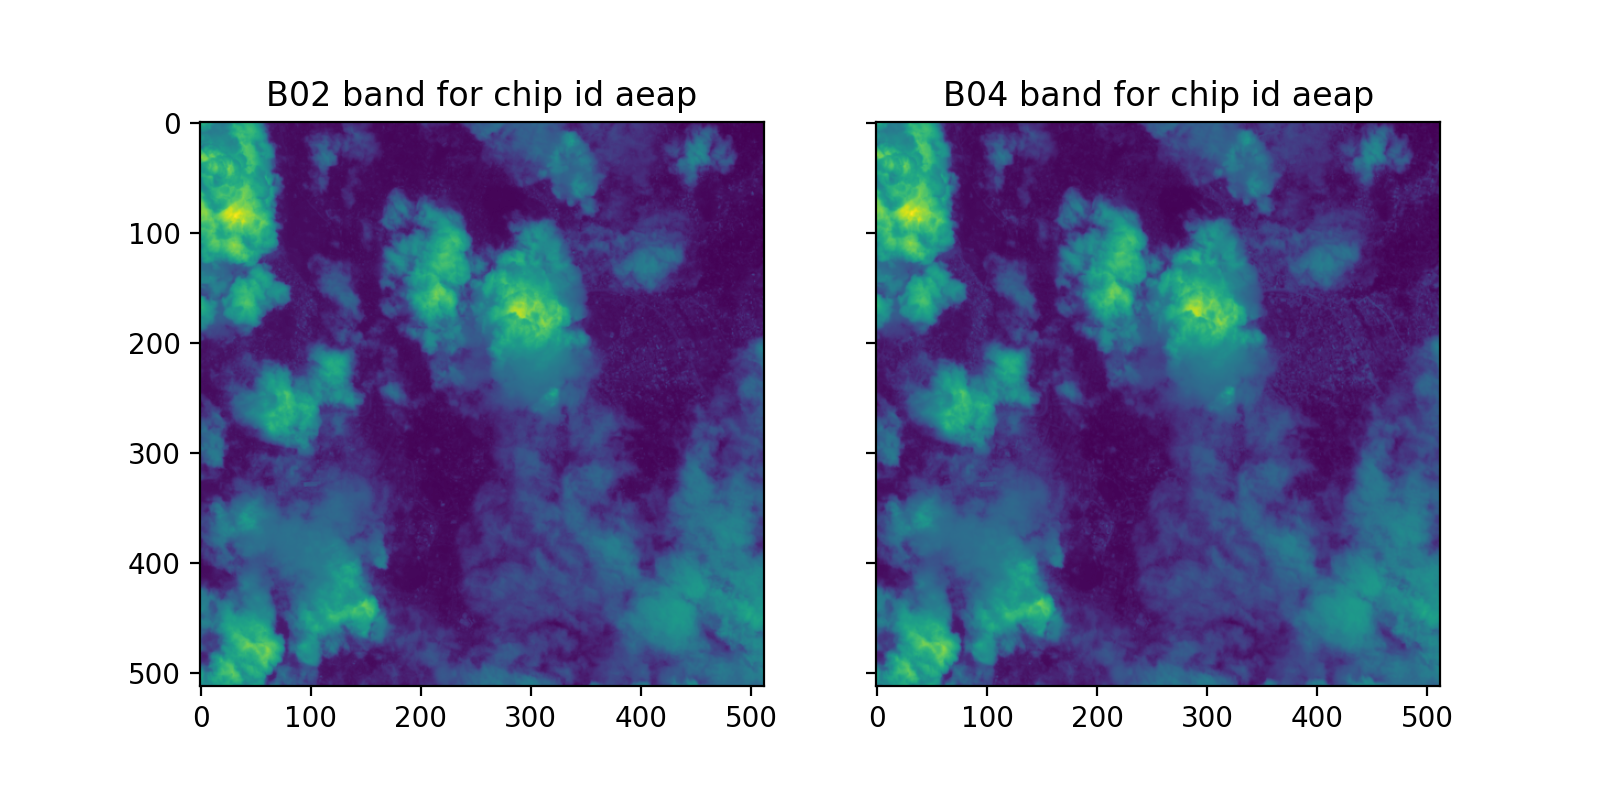

In [8]:
%matplotlib notebook 

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax[0].imshow(img_array_2)
ax[0].set_title(f"B02 band for chip id {example_chip.chip_id}")

ax[1].imshow(img_array_4)
ax[1].set_title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

In [9]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B02_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")
print(bounds)

Longitude: 32.909282925050576, latitude: -2.499979881187133
BoundingBox(left=487355.0, bottom=9721115.0, right=492475.0, top=9726235.0)


In [10]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")
print(bounds)

Longitude: 32.909282925050576, latitude: -2.499979881187133
BoundingBox(left=487355.0, bottom=9721115.0, right=492475.0, top=9726235.0)


In [11]:
src = rasterio.open(example_chip["B02_path"])
src.tags()

{'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2020-04-29T08:20:47Z'}

In [12]:
src = rasterio.open(example_chip["B04_path"])
src.tags()

{'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2020-04-29T08:20:47Z'}

In [13]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

left, bottom, right, top = lat_long_bounds(example_chip["B02_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (-2.5231419378890125, 32.886253114556204)
End: (-2.476817439936036, 32.932311928146675)


In [14]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    data_dir=TRAIN_FEATURES
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

def color2gray(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    data_dir=TRAIN_FEATURES
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")
    
    gray = red/3 + green/3 + blue/3

    return gray

<IPython.core.display.Javascript object>


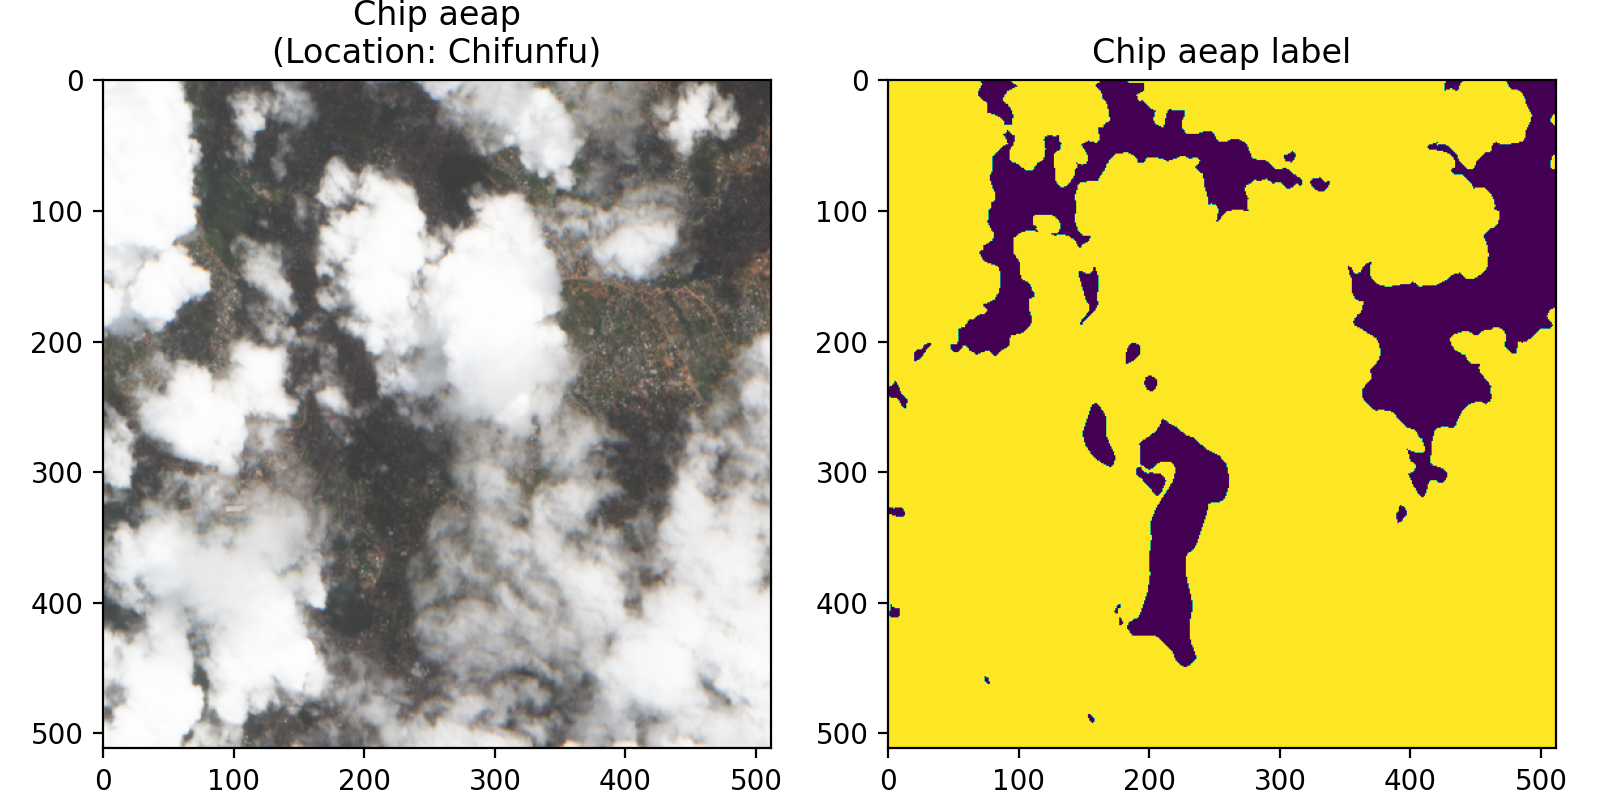

Total: 262144 = 221161
56 -- 255


In [15]:
# def display_random_chip(example_chip):
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
true_image = true_color_img(example_chip.chip_id)
ax[0].imshow(true_image)
ax[0].set_title(f"Chip {example_chip.chip_id}\n(Location: {example_chip.location})")
label_im = Image.open(example_chip.label_path)
ax[1].imshow(label_im)
ax[1].set_title(f"Chip {example_chip.chip_id} label")

plt.tight_layout()
plt.show()

print('Total:',512*512, '=', np.count_nonzero(np.array(Image.open(example_chip.label_path))))
print(np.array(true_image).min(), '--', np.array(true_image).max())

<IPython.core.display.Javascript object>


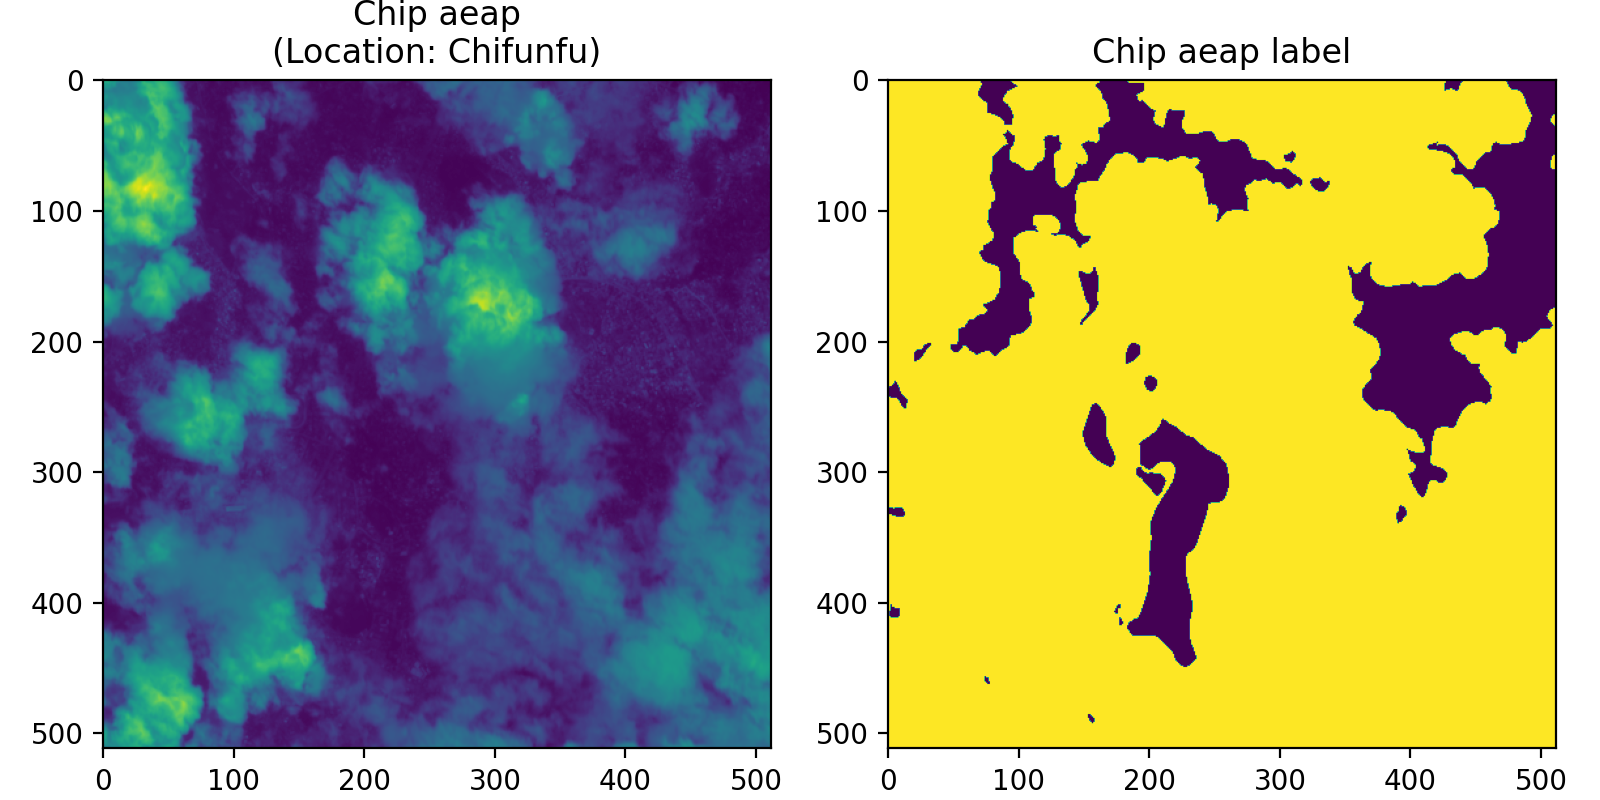

Total: 262144 = 221161


In [16]:
# def display_random_chip(example_chip):
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
gray_image = color2gray(example_chip.chip_id)
ax[0].imshow(gray_image)
ax[0].set_title(f"Chip {example_chip.chip_id}\n(Location: {example_chip.location})")
label_im = Image.open(example_chip.label_path)
ax[1].imshow(label_im)
ax[1].set_title(f"Chip {example_chip.chip_id} label")

plt.tight_layout()
plt.show()

print('Total:',512*512, '=', np.count_nonzero(np.array(Image.open(example_chip.label_path))))

<IPython.core.display.Javascript object>


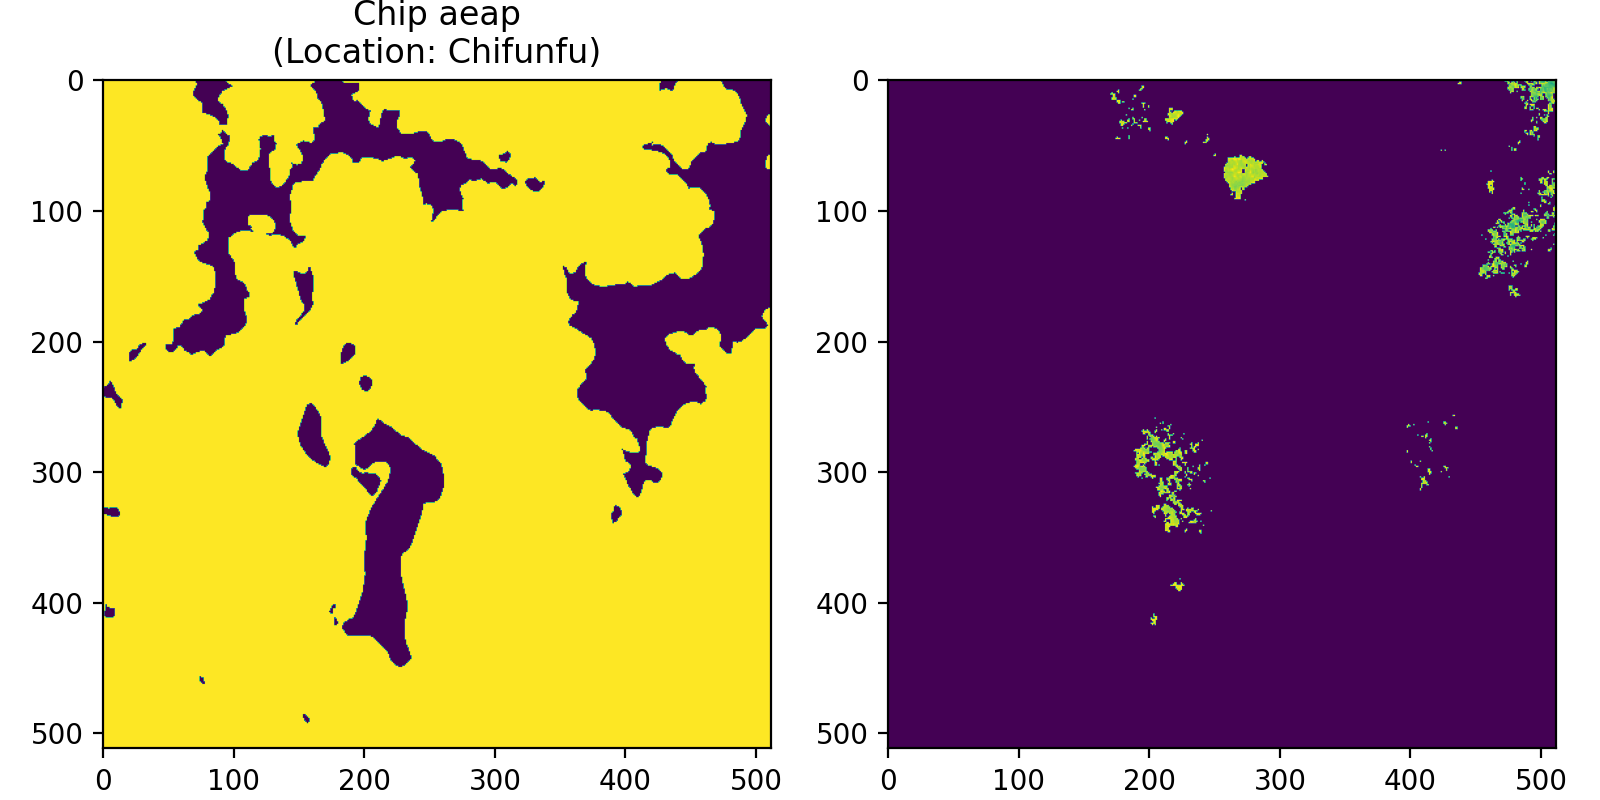

507.33333333333337 -- 13208.0


In [17]:
gray_array = np.array(gray_image)
cp_gray = np.copy(gray_array)
cp_gray[cp_gray > 700] = 254

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(label_im)
ax[0].set_title(f"Chip {example_chip.chip_id}\n(Location: {example_chip.location})")
ax[1].imshow(cp_gray)

plt.tight_layout()
plt.show()

print(gray_array.min(), '--', gray_array.max())

In [18]:
[np.random.randn(3, 4) for _ in range(3)]

[array([[ 0.68813336,  0.60302998,  0.66730126,  0.4255798 ],
        [-1.06195971, -0.10009461, -0.72856973,  0.92023003],
        [ 0.62999462, -0.18916437,  0.58948628,  0.83816859]]),
 array([[ 1.84663089, -0.50276753, -0.52685802,  1.28950724],
        [ 0.33015915,  0.13829499,  1.79994372, -1.32705169],
        [-1.10042731, -0.54084727,  0.95803504, -1.76784487]]),
 array([[-0.29483386,  0.53216996, -0.96535351, -0.42999638],
        [ 1.00680192,  2.03878504, -0.59039644,  1.42450338],
        [ 0.75097249, -0.90174561, -2.2603457 , -0.00828776]])]

In [19]:
import random
import warnings

warnings.filterwarnings("ignore")

from benchmark_src.cloud_dataset import CloudDataset
from benchmark_src.cloud_model import CloudModel

In [20]:
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((3877, 9), (7871, 9))

In [21]:
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

In [22]:
# Set up pytorch_lightning.Trainer object
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch", mode="max", verbose=True
)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

trainer = pl.Trainer(
    gpus=None,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/miloc/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
# Fit the model
trainer.fit(model=cloud_model)

AttributeError: 'functools.partial' object has no attribute '__name__'